# Data Collection

This notebook allows for the gathering of data from the World Bank, fills in missing values, and sorts it according to region. 


The plan to complete the data:
- --> missing data
- --> get data from previous years (range to be decided)
- --> missing data 
- --> average of countries with same region and incomegroup 
- --> missing data
- --> average of countries with same incomegroup
- --> missing data
- --> average of countries in same region


- other idea: look for most comparable country with data
- some indicaters might need to be scaled for population (income, energy production, ... ) 

We start by importing the required Python packages:

In [1]:
import wbdata
import datetime
import pandas as pd
import numpy as np

### Step 1: Regions and their countries

The World Bank has divided the world into several regions. The Excel file 'Regions.xslx' contains all the regions and their countries. In this step we import this data into a Pandas DataFrame. 

In [2]:
regions=pd.read_excel("Regions.xlsx", sheetname=0, header=0, skiprows=None, skip_footer=0, index_col='country', 
                      names=['Country Data','Region','IncomeGroup'],
                        parse_cols=None, parse_dates=False, date_parser=None, na_values=None, thousands=None, convert_float=True, has_index_names=None, converters=None, dtype=None, true_values=None, false_values=None, engine=None, squeeze=False)

The countries are ordered alphabetically:

In [3]:
regions.head()


,Country Data,Region,IncomeGroup
country,,,
Afghanistan,AFG,South Asia,Low income
Albania,ALB,Europe & Central Asia,Upper middle income
Algeria,DZA,Middle East & North Africa,Upper middle income
American Samoa,ASM,East Asia & Pacific,Upper middle income
Andorra,AND,Europe & Central Asia,High income


In [4]:
regions.tail()

,Country Data,Region,IncomeGroup
country,,,
Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income
West Bank and Gaza,PSE,Middle East & North Africa,Lower middle income
"Yemen, Rep.",YEM,Middle East & North Africa,Lower middle income
Zambia,ZMB,Sub-Saharan Africa,Lower middle income
Zimbabwe,ZWE,Sub-Saharan Africa,Low income


### Step 2: Function Definition

Here we define the functions that we will use to get the required data. 
- FillWithPreviousYears(): This function fills the dataframe with data from previous years. The range can be user-specified.
- FillByRegionAndIncome(): This function fills the dataframe with the mean value of countries in the same region AND the same incomelevel.
- FillByIncome(): This function fills missing values in the dataframe with the mean value of countries with the same income level. 
- FillByRegion(): This function fills missing values in the dataframe with the mean value of countries in the same region. 
- FillWithMean(): This function fills missing values in the dataframe with the mean of all the other countries. 
- DataCompleteness(): This function shows the completeness of the dataset. 
- SortData(): This function sorts the dataframe by region (and then alphabetically). 
- WriteToExcel(): This function writes the DataFrame to excel in the correct format. 

In [5]:
def FillWithPreviousYears(dataframe, year1=2000, year2=2015):
    """
    This function fills any missing data in the dataframe with data from previous years 
    (in the specified range).
    --------------
    Inputs:
    dataframe
    year1 (default=2000)
    year2 (default=2015)
    --------------
    """
    df_filled=dataframe
    for year in range(year2, year1, -1):
        data_date=(datetime.datetime(year,1,1), datetime.datetime(year,1,1))
        df_year= wbdata.get_dataframe(indicators, data_date=data_date)
        df_filled=df_filled.combine_first(df_year)
    number = dataframe.isnull().sum()-df_filled.isnull().sum() 
    print(number)
    return df_filled

In [6]:
def FillByRegionAndIncome(dataframe):
    filled_data=pd.DataFrame()
    for region in set(dataframe['Region']):
        for incomelevel in set(dataframe['IncomeGroup']):
            regional_data=dataframe.loc[(dataframe["Region"]==region) & (dataframe["IncomeGroup"]==incomelevel)]
            regional_data=regional_data.fillna(regional_data.mean())
            filled_data=filled_data.append(regional_data)
    return filled_data

In [7]:
def FillByIncome(dataframe):
    filled_data=pd.DataFrame()
    for incomelevel in set(dataframe['IncomeGroup']):
        income_data=dataframe.loc[(dataframe["IncomeGroup"]==incomelevel)]
        income_data=income_data.fillna(income_data.mean())
        filled_data=filled_data.append(income_data)
    return filled_data

In [8]:
def FillByRegion(dataframe):
    filled_data=pd.DataFrame()
    for region in set(dataframe['Region']):
        regional_data=dataframe.loc[(dataframe["Region"]==region)]
        regional_data=regional_data.fillna(regional_data.mean())
        filled_data=filled_data.append(regional_data)
    return filled_data

In [9]:
def FillWithMean(dataframe):
    """
    
    This function fills any missing data with the mean of the column. This step directly leads to a complete dataset, 
    but is not very sophisticated yet. Ideally, this could be rewritten to taking the mean of neighboring countries, or 
    the mean of the region of the country, or the mean of countries with the same income level. 
    --------------
    Inputs:
    dataframe: The dataframe with missing data. 
    
    """
    df_complete=dataframe.fillna(dataframe.mean())
    return df_complete

In [10]:
def DataCompleteness(dataframe):
    percentage = 100-(dataframe.isnull().sum()/len(dataframe))*100         # percentage of available data
    print(percentage)

In [11]:
def SortData(dataframe):
    data_sorted = dataframe.sort(columns=['Region', 'Country Code'])
    return data_sorted

In [12]:
def WriteToExcel(dataframe, filename='testdata.xlsx'):
    """
    This function writes the dataframe to excel. It writes each column to a new sheet, which is named as the first 
    32 characters of the indicator name (due to the name limit of 32 characters in Excel). 
    -------------
    Inputs:
    dataframe: The dataframe that should be written to Excel. 
    """
    writer = pd.ExcelWriter(filename)
    for column in dataframe:
        df_to_write=pd.DataFrame(dataframe[column])
        df_to_write.to_excel(writer, tabnames[column][:31])

In [13]:
def PopulationRanges(dataframe):
    new_df=dataframe.copy()
    new_df["Population0to14"]=dataframe["Population, ages 0-14, total"]
    male15to34columns=["Population ages 15-19, male (% of male population)",
                       "Population ages 20-24, male (% of male population)",
                       "Population ages 25-29, male (% of male population)",
                       "Population ages 30-34, male (% of male population)"]
    
    female15to34columns=["Population ages 15-19, female (% of female population)",
                         "Population ages 20-24, female (% of female population)",
                         "Population ages 25-29, female (% of female population)",
                         "Population ages 30-34, female (% of female population)"]
    
    male35to64columns=["Population ages 35-39, male (% of male population)",
                      "Population ages 40-44, male (% of male population)",
                      "Population ages 45-49, male (% of male population)",
                      "Population ages 50-54, male (% of male population)",
                      "Population ages 55-59, male (% of male population)",
                      "Population ages 50-64, male (% of male population)"] # Note: the indicatorcode says 60-64
    
    female35to64columns=["Population ages 35-39, female (% of female population)",
                      "Population ages 40-44, female (% of female population)",
                      "Population ages 45-49, female (% of female population)",
                      "Population ages 50-54, female (% of female population)",
                      "Population ages 55-59, female (% of female population)",
                      "Population ages 50-64, female (% of female population)"] # Note: the indicatorcode says 60-64
    
    malepop15to34percentage=dataframe[male15to34columns].sum(axis=1)/100
    femalepop15to34percentage=dataframe[female15to34columns].sum(axis=1)/100
    malepop35to64percentage=dataframe[male35to64columns].sum(axis=1)/100
    femalepop35to64percentage=dataframe[female35to64columns].sum(axis=1)/100
    #print(dataframe["Population, male"])
    
    new_df["Population0to14"]=dataframe["Population, ages 0-14, total"]
    new_df["Population15to34"]=malepop15to34percentage*dataframe["Population, male"]+femalepop15to34percentage*dataframe["Population, female"]
    new_df["Population35to64"]=malepop35to64percentage*dataframe["Population, male"]+femalepop35to64percentage*dataframe["Population, female"]
    new_df["PopulationOver65"]=(dataframe["Population ages 65 and above (% of total)"]/100)*dataframe["Population, total"]

    columns_to_drop=male15to34columns+female15to34columns+male35to64columns+female35to64columns+["Population, ages 0-14, total"]+["Population ages 65 and above (% of total)"]
    
    new_df.drop(columns_to_drop, axis=1, inplace=True)
    
    totalpop=new_df[["Population0to14","Population15to34","Population35to64","PopulationOver65"]].sum(axis=1)
    # print(totalpop)
    
    for country in new_df.index:
        if totalpop[country]-dataframe["Population, total"].loc[country]>10000:
            new_df["Population0to14"].loc[country]=new_df["Population0to14"].loc[country]/(totalpop[country]/new_df["Population, total"].loc[country])
            new_df["Population15to34"].loc[country]=new_df["Population15to34"].loc[country]/(totalpop[country]/new_df["Population, total"].loc[country])
            new_df["Population35to64"].loc[country]=new_df["Population35to64"].loc[country]/(totalpop[country]/new_df["Population, total"].loc[country])
            new_df["PopulationOver65"].loc[country]=new_df["PopulationOver65"].loc[country]/(totalpop[country]/new_df["Population, total"].loc[country])
            
    newtotalpop=new_df[["Population0to14","Population15to34","Population35to64","PopulationOver65"]].sum(axis=1)        
    tabnames['Population0to14']='Population0to14'
    tabnames['Population15to34']='Population15to34'
    tabnames['Population35to64']='Population35to64'
    tabnames['PopulationOver65']='PopulationOver65'
    diff=newtotalpop-dataframe["Population, total"]
    x=diff>10000
    print(x.sum(), "countries have their populations deviate significantly.")
    #print(diff)

    return new_df
    


### Step 3: Retrieving the World Bank Data

Now we can use the 'wbdata' package to import any data that we would like from the World Bank. At this point, this is limited to the 'World Development Indicators' (Source 2). The following command will show all indicators that are contained in this dataset:

In [14]:
x =pd.DataFrame(wbdata.get_indicator(source=2))

SE.SEC.ENRR              	Gross enrolment ratio, secondary, both sexes (%)
SE.SEC.ENRL.VO.FE.ZS     	Percentage of students in secondary vocational education who are female (%)
SE.SEC.ENRL.VO           	Enrolment in secondary vocational, both sexes (number)
SE.SEC.ENRL.UP.TC.ZS     	Pupil-teacher ratio, upper secondary
SE.SEC.ENRL.TC.ZS        	Pupil-teacher ratio in secondary education (headcount basis)
SE.SEC.ENRL.LO.TC.ZS     	Pupil-teacher ratio, lower secondary
SE.SEC.ENRL.GC.FE.ZS     	Percentage of students in secondary general education who are female (%)
SE.SEC.ENRL.GC           	Enrolment in secondary general, both sexes (number)
SE.SEC.ENRL.FE.ZS        	Secondary education, pupils (% female)
SE.SEC.ENRL              	Enrolment in secondary education, both sexes (number)
SE.SEC.DURS              	Theoretical duration of secondary education (years)
SE.SEC.CUAT.UP.ZS        	Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)
SE.S

It is also possible to search the indicators:

In [15]:
indicator_dataframe = pd.ExcelFile("All_Indicators.xlsx").parse('Sheet1')

In [16]:
indicator_dataframe.head()

,Indicator,Description,Tabname
0,per_si_allsi.adq_pop_tot,Adequacy of social insurance programs (% of to...,NaN
1,per_allsp.adq_pop_tot,Adequacy of social protection and labor progra...,NaN
2,per_sa_allsa.adq_pop_tot,Adequacy of social safety net programs (% of t...,NaN
3,per_lm_alllm.adq_pop_tot,Adequacy of unemployment benefits and ALMP (% ...,NaN
4,per_lm_alllm.cov_pop_tot,Coverage (%) - All Labor Market,NaN


In [17]:
indicators=indicator_dataframe.set_index('Indicator').to_dict()['Description']

In [18]:
tabnames=indicator_dataframe.set_index('Description').to_dict()['Tabname']

In [19]:
indicator_dataframe["Tabname"] = "Not available"
indicator_dataframe.head()

,Indicator,Description,Tabname
0,per_si_allsi.adq_pop_tot,Adequacy of social insurance programs (% of to...,Not available
1,per_allsp.adq_pop_tot,Adequacy of social protection and labor progra...,Not available
2,per_sa_allsa.adq_pop_tot,Adequacy of social safety net programs (% of t...,Not available
3,per_lm_alllm.adq_pop_tot,Adequacy of unemployment benefits and ALMP (% ...,Not available
4,per_lm_alllm.cov_pop_tot,Coverage (%) - All Labor Market,Not available


In [20]:
wbdata.search_indicators('code', source=2)

The chosen indicators can be put in the dictionary below:

# Search for the right indicator(s)

In [21]:
#Step towards df creation
inputs = []
inp = 0
while inp != "stop":
    inp = input("Enter indicator code (for choropleth max 1) or stop: ")
    if inp != "stop":
        inputs.append(inp)

Enter indicator code (for choropleth max 1) or stop: VC.IHR.PSRC.P5
Enter indicator code (for choropleth max 1) or stop: stop


In [22]:
inputs

['VC.IHR.PSRC.P5']

In [23]:
def get_description(i):
    inputdes = indicator_dataframe[indicator_dataframe["Indicator"] == i]["Description"]
    desired_des = inputdes.get_value(inputdes.index[0])
    return desired_des

In [24]:
des_desc = []
for i in inputs:
    des_desc.append(get_description(i))

In [25]:
desired_ind = {}
for i in range(0, len(inputs)):
    desired_ind[inputs[i]] = des_desc[i]
print(desired_ind)

{'VC.IHR.PSRC.P5': 'Intentional homicides (per 100,000 people)'}


Of course we prefer to have the most recent data, so we start by looking at the data for 2016.

In [26]:
data_date=(datetime.datetime(input("Enter starting year: "),1,1), datetime.datetime(input("Enter ending year: "),1,1))

In [27]:
indicators

{'per_si_allsi.adq_pop_tot': 'Adequacy of social insurance programs (% of total welfare of beneficiary households)',
 'per_allsp.adq_pop_tot': 'Adequacy of social protection and labor programs (% of total welfare of beneficiary households)',
 'per_sa_allsa.adq_pop_tot': 'Adequacy of social safety net programs (% of total welfare of beneficiary households)',
 'per_lm_alllm.adq_pop_tot': 'Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)',
 'per_lm_alllm.cov_pop_tot': 'Coverage (%) - All Labor Market ',
 'per_sa_allsa.cov_pop_tot': 'Coverage (%) - All Social Assistance ',
 'per_si_allsi.cov_pop_tot': 'Coverage (%) - All Social Insurance ',
 'per_allsp.cov_pop_tot': 'Coverage (%) -All Social Protection and Labor ',
 'EG.CFT.ACCS.ZS': 'Access to clean fuels and technologies for cooking',
 'EG.ELC.ACCS.ZS': 'Access to electricity (% of population)',
 'EG.ELC.ACCS.RU.ZS': 'Access to electricity, rural (% of rural population)',
 'EG.ELC.ACCS.UR.ZS': 'Ac

In [28]:
df = wbdata.get_dataframe(desired_ind, data_date=data_date)

In [29]:
desired_ind

{'VC.IHR.PSRC.P5': 'Intentional homicides (per 100,000 people)'}

### Step 4: Filling the blanks

We now have a dataframe with the data that we specified in the dictionary. However, there is a lot of missing data:


In [30]:
DataCompleteness(df)

Intentional homicides (per 100,000 people)    17.104232
dtype: float64


So let's start the filling of missing values by looking at previous years: 

Short in-between step to filter for countries (as in Regions.xslx):

In [31]:
df_years2 = regions.join(df, how='outer')

This has already improved the dataset significantly. However, there is still a lot of data missing. The second step is to fill in missing values with the mean value of countries in the same region, with the same income level. 

In [32]:
df_region_income = FillByRegionAndIncome(df_years2)

In [33]:
DataCompleteness(df_region_income)

Country Data                                  100.0
Region                                        100.0
IncomeGroup                                   100.0
Intentional homicides (per 100,000 people)    100.0
dtype: float64


In the worst case, this leads to about 12% of the data not filled yet. We can fill this by taking the average of countries with the same income level.

In [34]:
df_income=FillByIncome(df_region_income)

In [35]:
DataCompleteness(df_income)

Country Data                                  100.0
Region                                        100.0
IncomeGroup                                   100.0
Intentional homicides (per 100,000 people)    100.0
dtype: float64


We have reached 100% for the current indicators! If data is still missing, we could fill it by looking at countries from the same region:

In [36]:
df_region = FillByRegion(df_income)

In [37]:
DataCompleteness(df_region)

Country Data                                  100.0
Region                                        100.0
IncomeGroup                                   100.0
Intentional homicides (per 100,000 people)    100.0
dtype: float64


And then we could fill with the mean value of all countries: 

In [38]:
df_mean=FillWithMean(df_region)

In [39]:
DataCompleteness(df_mean)

Country Data                                  100.0
Region                                        100.0
IncomeGroup                                   100.0
Intentional homicides (per 100,000 people)    100.0
dtype: float64


### Step 5 : Visualize

In [40]:
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy import array

from numpy import meshgrid

In [41]:
df_mean["Country"] = df_mean["Country Data"]
df_mean.head()

Country Data                      Region          IncomeGroup  \
country  date                                                                 
Djibouti 2017          DJI  Middle East & North Africa  Lower middle income   
         2016          DJI  Middle East & North Africa  Lower middle income   
         2015          DJI  Middle East & North Africa  Lower middle income   
         2014          DJI  Middle East & North Africa  Lower middle income   
         2013          DJI  Middle East & North Africa  Lower middle income   

               Intentional homicides (per 100,000 people) Country  
country  date                                                      
Djibouti 2017                                    2.479328     DJI  
         2016                                    2.479328     DJI  
         2015                                    6.800000     DJI  
         2014                                    2.479328     DJI  
         2013                                    2.479328     DJI

In [42]:
value = des_desc[0]

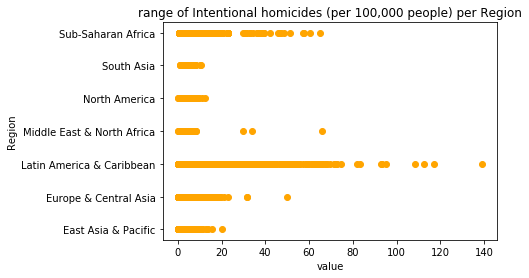

In [43]:
x = df_mean[value]
y = df_mean["Region"]
plt.scatter(x, y, label='linear', color = "orange", )
plt.xlabel("value")
plt.ylabel("Region")
plt.title("range of " + value + " per Region")
plt.show()

In [44]:
df_mean[value + "Standardized"] = (df_mean[value] - df_mean[value].min()) / (df_mean[value].max() - df_mean[value].min())

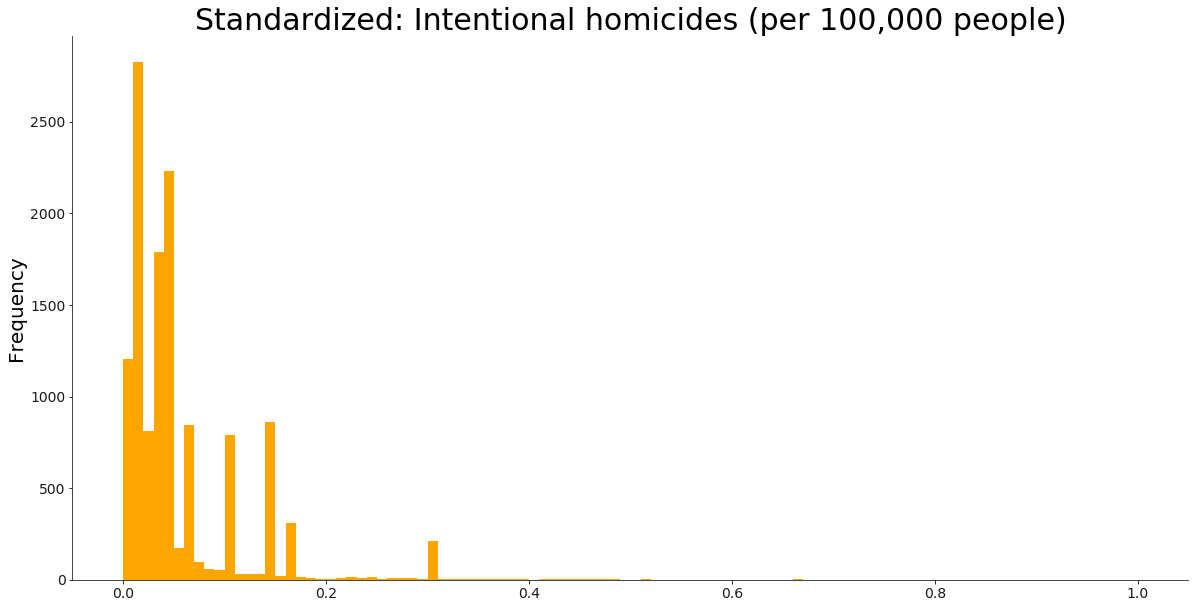

In [45]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.spines['left'].set_color('#1a1a1a')
ax.spines['bottom'].set_color('#1a1a1a')

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

plt.xticks(fontsize=14, color='#1a1a1a')  
plt.yticks(fontsize=14, color='#1a1a1a')

plt.title('Standardized: ' + value, fontsize=30)
plt.xlabel('', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.hist(df_mean[value + "Standardized"], bins=100, color= "orange");
plt.show()

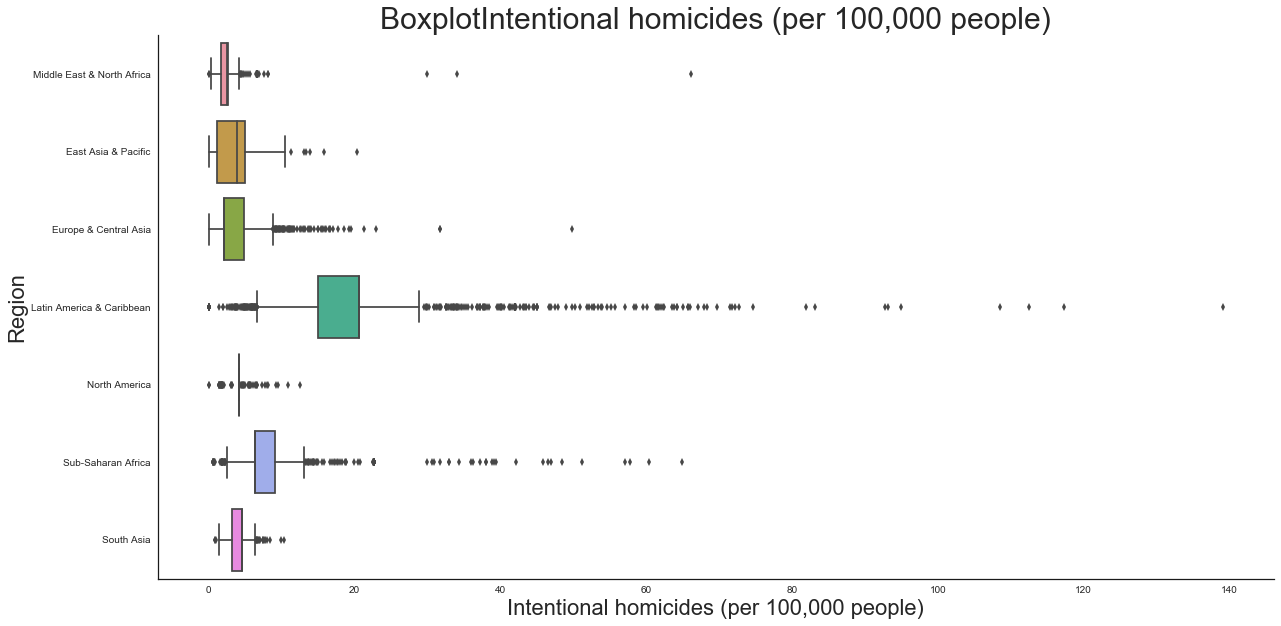

In [46]:
import seaborn as sns

sns.set(style="white", color_codes=True)

fig, ax = plt.subplots(figsize=(20, 10))

ax.spines["top"].set_visible(False) 
ax.spines["right"].set_visible(False)

ax.spines['left'].set_color('#1a1a1a')
ax.spines['bottom'].set_color('#1a1a1a')

plt.title('Boxplot' + value, fontsize=30)
plt.ylabel("Region", fontsize=22)
plt.xlabel(value, fontsize=22)

boxplot1 = sns.boxplot(x=df_mean[value], y=df_mean["Region"], orient='h' );
plt.show()

### Step 6: Klaar zetten voor timeslider

In [47]:
df_ts=df_mean.reset_index()
df_ts.head()
df_ts= df_ts.pivot(index='country', columns='date', values= value).reset_index()

In [48]:
df_mean.groupby(by = ['country','Country']).mean().reset_index()["Country"]
df_ts.insert(column = 'Country Code', value = df_mean.groupby(by = ['country','Country']).mean().reset_index()["Country"], loc = 1)
df_ts.insert(column = "Indicator Name", value = des_desc[0], loc = 2)
df_ts.insert(column = "Indicator Code", value = inputs[0], loc = 3)


In [49]:
df_mean.head()

Country Data                      Region          IncomeGroup  \
country  date                                                                 
Djibouti 2017          DJI  Middle East & North Africa  Lower middle income   
         2016          DJI  Middle East & North Africa  Lower middle income   
         2015          DJI  Middle East & North Africa  Lower middle income   
         2014          DJI  Middle East & North Africa  Lower middle income   
         2013          DJI  Middle East & North Africa  Lower middle income   

               Intentional homicides (per 100,000 people) Country  \
country  date                                                       
Djibouti 2017                                    2.479328     DJI   
         2016                                    2.479328     DJI   
         2015                                    6.800000     DJI   
         2014                                    2.479328     DJI   
         2013                                    2.479328     DJI   

               Intentional homicides (per 100,000 people)Standardized  
country  date                                                          
Djibouti 2017                                           0.017820       
         2016                                           0.017820       
         2015                                           0.048874       
         2014                                           0.017820       
         2013                                           0.017820

In [50]:
df_ts.head()

date,country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,"Intentional homicides (per 100,000 people)",VC.IHR.PSRC.P5,3.276059,3.276059,3.276059,3.276059,3.276059,3.276059,...,3.276059,4.100000,3.500000,4.300000,6.600000,3.276059,3.276059,3.276059,3.276059,3.276059
1,Albania,ALB,"Intentional homicides (per 100,000 people)",VC.IHR.PSRC.P5,4.837708,4.837708,4.837708,4.837708,4.837708,4.837708,...,3.100000,2.900000,4.400000,4.900000,5.500000,4.300000,4.000000,2.300000,4.837708,4.837708
2,Algeria,DZA,"Intentional homicides (per 100,000 people)",VC.IHR.PSRC.P5,6.690000,6.690000,6.690000,6.690000,6.690000,6.690000,...,0.900000,0.800000,0.700000,0.800000,1.400000,1.300000,1.500000,1.400000,6.690000,6.690000
3,American Samoa,ASM,"Intentional homicides (per 100,000 people)",VC.IHR.PSRC.P5,3.859853,3.859853,3.859853,3.859853,3.859853,3.859853,...,3.859853,3.859853,3.859853,3.859853,3.859853,3.859853,3.859853,3.859853,3.859853,3.859853
4,Andorra,AND,"Intentional homicides (per 100,000 people)",VC.IHR.PSRC.P5,2.185179,2.185179,2.185179,2.185179,2.185179,2.185179,...,1.200000,1.200000,1.200000,1.200000,0.000000,0.000000,0.000000,0.000000,2.185179,2.185179


In [51]:
file_path = ''
data_file = 'GDP per capita countries.xls'

def Create_Timesliderdata_Excel(file):
    """Prepare exceldata for TimesliderChoropleth"""
    
    #load model results
    countries_xlsx = file
    country_data = pd.read_excel(countries_xlsx, 'Data', skiprows = 3)
    
    print (country_data.iloc[0,:10])
    start_column = int(input("In what row does the data start? ")) - 1
    
    
    country_data.insert(column = 'BASE', value = 0, loc = start_column)
    country_data = country_data.fillna(method = "ffill", axis = 1)
    
    
    return country_data

def create_pngs(output_dicts, prefix):
   
    try:
        # create the API client instance
        client = pdfcrowd.HtmlToImageClient('dwolffenbuttel', '0463db73b38598120638c80f0b57a338')

        # configure the conversion
        client.setOutputFormat('png')
    
        client.setScreenshotHeight(800)
        client.setScreenshotWidth(1200)
        x = 0
        for year in output_dicts:
            x+=1
            # run the conversion and write the result to a file
            client.convertFileToFile(file_path + prefix+year+'.html', prefix+year+'.png')
            print("Progress converting to png {:2.1%}     ".format( x / len(output_dicts)), end="\r")
            
            
    except pdfcrowd.Error as why:
         # report the error to the standard error stream
        sys.stderr.write('Pdfcrowd Error: {}\n'.format(why))

def TimesliderChoroplethCreator(country_data, file_path):
    """Creates html maps per year and aggregates movie of maps
    
    Input = list of [countries,country_data,geo_json_data], provided by "Create_Timesliderdata_Excel(file)"
    
    """
    # Import shapefiles world
    countries = file_path + 'world.geo.json-master/countries.geo.json'
    geo_json_data = json.load(open(countries))

    
    # Create dictionary of dictionaries containing map info
    output_dicts = {}
    for year in country_data.columns[5:]:
        output_dicts[year] = country_data.set_index("Country Code")[year]
    
    # Create dictionary containing colormaps of map
    colormap = {}
    
    # Let user decide on colorscheme for maps
    colors = []
    inp = 0
    while inp != "stop":
        inp = input("Enter colorscheme, colour for low values first, color for high values last. End with stop ")
        if inp != "stop":
            colors.append(inp)
        
        
    for year in output_dicts:
        colormap[year] = cm.LinearColormap(colors=colors).scale(
            country_data[year].min(),
            country_data[year].max())   
        
    # Create map with shapefiles
    for feature in geo_json_data['features']:
        child1 = folium.GeoJson(
            data={
                "type": feature['geometry']['type'],
                "coordinates":  feature['geometry']['coordinates'],
                "id": feature['id']},
            name=feature['properties']['name'],
            style_function = lambda feature: dict(color='grey', weight= 0),
            control=False,
        )
    # Create dictionary of figures
    fg_output = {}
    m = {}
    for year in output_dicts:
    
        m[year] = folium.Map(location=[52, 5], zoom_start=2)
    # Create empty layers
        fg_output[year]=folium.FeatureGroup(name=year)
    
    # Color layers based on color patterns
    for year in output_dicts:
        fg_output[year].add_child(folium.GeoJson(
            geo_json_data,
            name= year,
            style_function=lambda feature: {
                'fillColor': colormap[year](output_dicts[year][feature['id']]),
                'color': 'black',
                'weight': 1,
                'dashArray': '5, 5',
                'fillOpacity': 0.9,
            },
        ))
    # Add all layers to the map
    for year in output_dicts:
        fg_output[year].add_to(m[year])
        
    # Make a layercontrol button
    region = "world"
    var_name = country_data["Indicator Name"][0]
    x = 0
    for year in output_dicts:
        folium.LayerControl(position='topright',collapsed=False).add_to(m[year])
        #save map as html file
        m[year].save(os.path.join("results", region +"_" + var_name + "_map_" + year +'.html'))
        x +=1
        print("Progress creating html maps {:2.1%}".format( x / len(output_dicts)), end="\r")
        
        
    # Turn HTML-maps into PNG's
    create_pngs(output_dicts, 'results/'+ region +"_" + var_name + "_map_")
    
    # Create mp4 from PNG's
    files = []
    images = []
    for year in output_dicts:
        files.append("results/"+ region +"_" + var_name + "_map_"+ str(year)+ ".png")
    for file in files:
        images.append(imageio.imread(file))

    imageio.mimsave(file_path + 'results/'+ region +"_" + var_name + "_map_time" + ".mp4", images)
    print("Animation created                                            ")

In [52]:

import pandas as pd
import json
import folium
from folium import IFrame
import os
from branca.colormap import linear
import matplotlib.pyplot as plt
import mpld3
from mpld3.plugins import LineLabelTooltip, connect
import imageio
import pdfcrowd
import sys
import wbdata
import branca.colormap as cm
file_path = ''
#data_file = 'GDP per capita countries.xls'
#data = Create_Timesliderdata_Excel(file_path + data_file)

TimesliderChoroplethCreator( df_ts ,file_path)


Enter colorscheme, colour for low values first, color for high values last. End with stop lightskyblue
Enter colorscheme, colour for low values first, color for high values last. End with stop yellow
Enter colorscheme, colour for low values first, color for high values last. End with stop red
Enter colorscheme, colour for low values first, color for high values last. End with stop stop
Animation created                                            
